<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/7_SHAP_Fed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet fastai==2.2.5

In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dataset import

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
data = pd.get_dummies(data)
feature_names = mf.get_col(data)

# Model import

## XGBoost

In [5]:
categorical_features = np.arange(178,1091).tolist()

In [6]:
pd.options.mode.chained_assignment = None
X_test = mf.get_set('test_id', data, 'MLP')

**Importante**: se il modello è trainato su GPU, quando si carica bisogna attivare il runtime con GPU, sennò il modello non vine caricato nel modo corretto. 

In [7]:
load = True
if load:
  from tensorflow import keras
  model = keras.models.load_model('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/MLP/fed_mlp')

Issue: https://github.com/slundberg/shap/issues/452

Vedere https://github.com/dmlc/xgboost/blob/master/demo/gpu_acceleration/shap.ipynb

In [8]:
# booster = xgb.get_booster()
# booster.predict(X_test.to_numpy(), pred_contribs = True, validate_features=False)

# SHAP

**Idea**

A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

**Definition**

The Shapley value is the average marginal contribution of a feature value across all possible coalitions. 

The Shapley value is NOT the difference in prediction when we would remove the feature from the model. 

**Interpretation**

Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

**Theoretical algorithm**

Per determinare il valore di Shapley della feature x_j, si elimina la feature dal dataset, e delle altre si fanno tutte le possibili estrazioni, andando a fare la predizione solo con le feature selezionate e aggiungendo x_j. Facendo la differenza tra ogni predizione con e senza x_j si ottiene il contributo marginale di x_j. 
Per fare la predizione con il modello quando delle feature sono state eliminate, si rimpiazzano i loro valori con valori random (ovviamente tra quelli delle feature rimosse) estratti dal dataset. 


**Implementation**

SHAP turns the Shapley values method into an optimization problem and uses a special kernel function to measure proximity of data instances. The results of SHAP are sparse

**Riferimenti**

Repo github: https://github.com/slundberg/shap

Tutorial (vedere parte per RF): https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

Grafici con codice funzionante: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html?highlight=classification



In [9]:
!pip install --quiet shap

     |████████████████████████████████| 358kB 4.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491630 sha256=e31f6c25f9453a6a47337e48b0efb00d11d33afbc0f326cc6625c1caad4e4051
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [10]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_test.to_numpy(), 10))#100))

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


In [11]:
lista = np.arange(100,120).tolist()
x = X_test.iloc[[0,1,20,56]].to_numpy()
y = X_test.iloc[lista].to_numpy()
z = np.concatenate((x,y), axis=0)
kernel_shap = explainer.shap_values(z) #sono i valori di shapley
# kernel_shap[1].shape

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `

In [15]:
kernel_shap

[array([[ 0.        ,  0.00128995,  0.00377647, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.00539754, ...,  0.        ,
          0.        ,  0.        ],
        [-0.01134514,  0.00085614, -0.01071216, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.00906928,  0.        ,  0.00063509, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00354993, -0.00175415, -0.02508729, ...,  0.        ,
          0.        ,  0.        ],
        [-0.03711096, -0.00413946, -0.01022788, ...,  0.        ,
          0.        ,  0.        ]])]

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][0,:], feature_names=feature_names)

In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][1,:], feature_names=feature_names)

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][2,:], feature_names=feature_names)

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][3,:], feature_names=feature_names)

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][8,:], feature_names=feature_names)

In [21]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][12,:], feature_names=feature_names)

In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][13,:], feature_names=feature_names)

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][14,:], feature_names=feature_names)

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][15,:], feature_names=feature_names)

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][16,:], feature_names=feature_names)

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][18,:], feature_names=feature_names)

In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0][19,:], feature_names=feature_names)

In [ ]:
# y = X_test.iloc[0:2].to_numpy()
# kernel_shap = explainer.shap_values(y) #sono i valori di shapley
# # kernel_shap[0].shape

In [ ]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], kernel_shap[1][0,:], feature_names=feature_names)

In [ ]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], kernel_shap[1][1,:], feature_names=feature_names)

In [ ]:
data

In [28]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0], feature_names=feature_names)

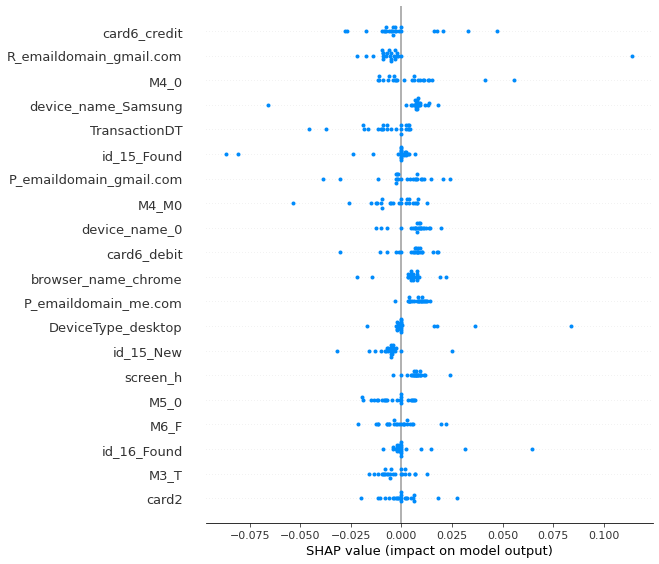

In [29]:
shap.summary_plot(kernel_shap[0], feature_names=feature_names)

Decision plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html?highlight=plot

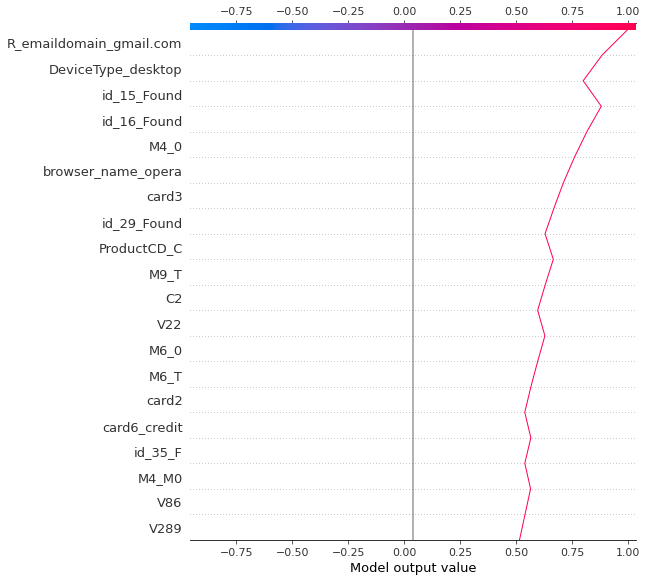

In [30]:
shap.decision_plot(explainer.expected_value, kernel_shap[0][0,:], feature_names=feature_names)

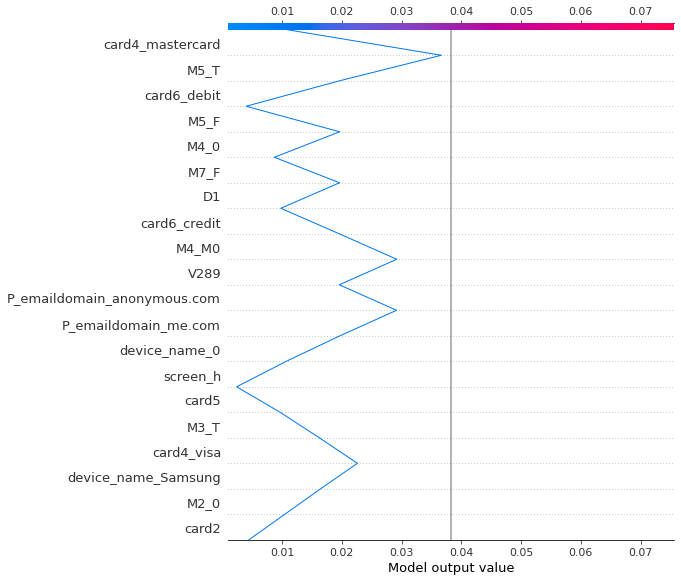

In [31]:
shap.decision_plot(explainer.expected_value, kernel_shap[0][1,:], feature_names=feature_names)

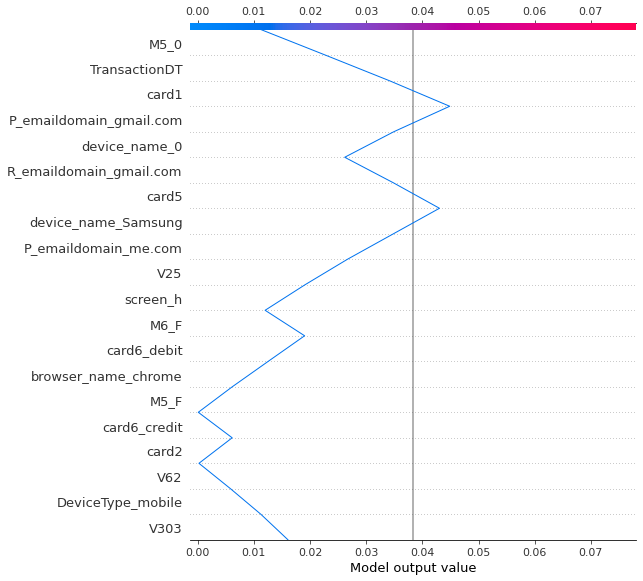

In [32]:
shap.decision_plot(explainer.expected_value, kernel_shap[0][2,:], feature_names=feature_names)

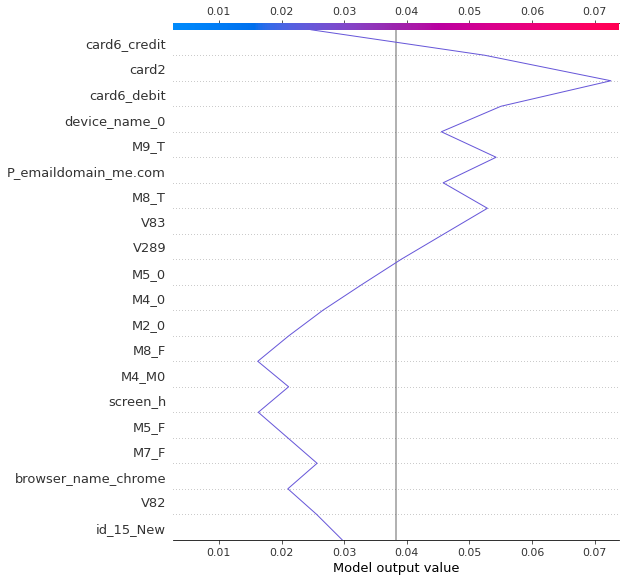

In [33]:
shap.decision_plot(explainer.expected_value, kernel_shap[0][3,:], feature_names=feature_names)

Shap values con permutations. 

In [ ]:
# import shap
# explainer = shap.explainers.Permutation(xgb.predict_proba, shap.sample(X_test.to_numpy(), 100))
# shap_values = explainer(X_test.to_numpy()[:10])
# shap_values